In [1]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from evaluate import compute_sim, evaluate

def l2norm(embs):
    return {k: v/np.linalg.norm(v) for k, v in embs.items()}

# infer_dir = 'D:'
# infer_dir = '/Users/macbook/Downloads'
infer_dir = 'infer/b5_768_gem_25e_cutout'
submit_file = f'submission_{infer_dir.split("/")[-1]}.csv'
if os.path.exists('D:/whale_data/train_images-384-384/train_images-384-384'):
    train_img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
else:
    train_img_dir = '/Users/macbook/works/train_images-384-384'

train_embs = pickle_load(f"{infer_dir}/train_emb.pkl")
test_embs = pickle_load(f"{infer_dir}/test_emb.pkl")
val_embs = pickle_load(f"{infer_dir}/val_emb.pkl")
train_df = pd.read_csv('data/train_kfold.csv')

# train_embs = l2norm(train_embs)
# test_embs = l2norm(test_embs)
# val_embs = l2norm(val_embs)
len(train_embs) + len(val_embs)

51033

In [2]:
val_df = train_df[train_df.subset == 'test'].reset_index()
val_map = dict(zip(val_df.image, val_df.individual_id))
train_map = dict(zip(train_df.image, train_df.individual_id))
# val_imgs = val_df.image.unique()
# val_embs = {k: train_embs[k] for k in val_imgs}

In [3]:
from evaluate import compute_sim, evaluate, map_per_image

score, val_sim_df = evaluate(train_df, train_embs, val_embs)
val_sim_df["gt"] = val_sim_df.image.map(val_map)
val_sim_df["map"] = val_sim_df.apply(lambda row: map_per_image(row["gt"], row.predictions.split(" ")), axis=1)
val_sim_df = val_sim_df.sort_values("map")
score

100%|██████████| 10207/10207 [00:07<00:00, 1340.14it/s]


0.48993664478625776

In [4]:
from evaluate import dict2list
train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(val_embs)
class_count_df = train_df.groupby('individual_id').size().to_frame('count').reset_index()
class_count = dict(zip(class_count_df.individual_id, class_count_df['count']))

cosines = np.matmul(test_v, train_v.T)

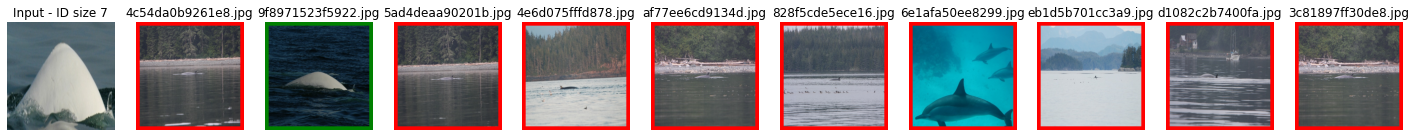

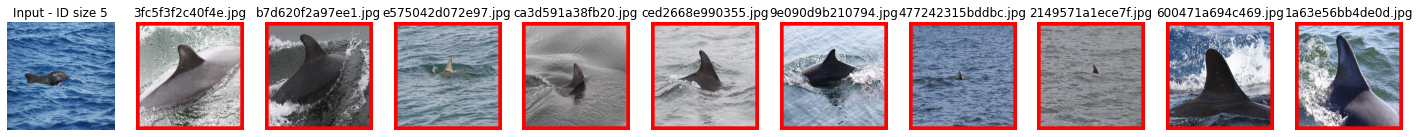

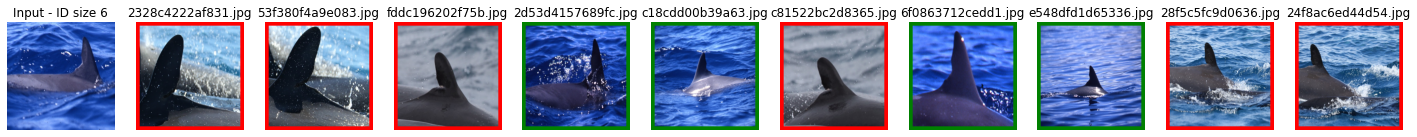

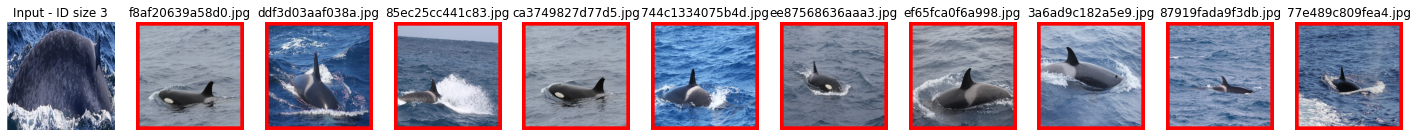

In [5]:
def add_border(img, color):
    bordersize = 14
    return cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=color
    )

c = 0
for i, scores in enumerate(cosines):
    if np.random.rand() < 0.5:
        sort_idx = np.argsort(scores)[::-1]
        topk = [train_k[j] for j in sort_idx[:10]]
        topk_id = [train_map[x] for x in topk]
        qid = test_k[i]
        gt = train_map[qid]
        c+=1
        imgs = [cv2.imread(f'{train_img_dir}/{qid}')[:,:,::-1]]
        for k, l in zip(topk, topk_id):
            im = cv2.imread(f'{train_img_dir}/{k}')[:,:,::-1]
            im = add_border(im, color=(255, 0, 0) if gt != l else (0, 128, 0))
            imgs.append(im)
        # Show image
        fig = plt.figure(figsize=(25, 4))
        columns = 11
        rows = 1
        for i2 in range(0, columns*rows):
            fig.add_subplot(rows, columns, i2+1)
            plt.title(f'Input - ID size {class_count[gt]}' if i2 == 0 else topk[i2 - 1])
            plt.imshow(imgs[i2])
            plt.axis('off')
        
        plt.show()
        
    if c == 4:
        break
    

In [6]:
# val_sim_df

sim_df = compute_sim(train_df, {**train_embs, **val_embs}, test_embs, thr=0.65)
sim_df[["image", "predictions"]].to_csv(submit_file.replace(".csv", "v1.csv"), index=False)
sim_df.head()

100%|██████████| 27956/27956 [00:25<00:00, 1099.05it/s]


,image,predictions
0,000110707af0ba.jpg,fbe2b15b5481 new_individual cfb7f2997ecf f9b0b...
1,00150406ce5395.jpg,2280b5fcc6c2 new_individual 18a4099e6f4d 1fc44...
2,002e8dd5f03476.jpg,new_individual 3ab9313cbb32 86dcdab8ff88 1974b...
3,00408e82bc01f3.jpg,6642e34b23c8 new_individual 356bfeac5626 462db...
4,0063923659a874.jpg,new_individual ce6e37904aa4 88f17b2d86df 17cd2...


In [7]:
# raise
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=100,metric='cosine')

train_k, train_v = dict2list({**train_embs, **val_embs})
test_k, test_v = dict2list(test_embs)
knn.fit(train_v)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [8]:
distances, idxs = knn.kneighbors(test_v, 100, return_distance=True)

In [9]:
from tqdm import tqdm

test_df = []
train_k = np.asarray(train_k)
img2id = dict(zip(train_df.image, train_df.individual_id))

for i in tqdm(range(len(test_k))):
    dist, idx = distances[i], idxs[i]
    for d, id in zip(dist, idx):
        img_id = train_k[id]
        tar = img2id[img_id]
        test_df.append([test_k[i], tar, d]) 
    

test_df = pd.DataFrame(test_df, columns=['image', 'target', 'distances'])
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

100%|██████████| 27956/27956 [00:03<00:00, 7204.10it/s]


32     505
34     499
37     492
23     491
31     487
      ... 
97      10
95       9
98       7
99       3
100      1
Name: image, Length: 100, dtype: int64

In [10]:
predictions = {}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

for i,row in tqdm(test_df.iterrows(), total=len(test_df)):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence > 0.5:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]

for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv(submit_file,index=False)
predictions.head()

100%|██████████| 27956/27956 [00:00<00:00, 964157.07it/s]


,image,predictions
0,f628b07bdea128.jpg,191e293af2b5 new_individual f63a97e9af3e 416c4...
1,5c9e04a6e6a9a2.jpg,547afd43d437 new_individual 6e104e471c72 c295e...
2,36518b7c407b40.jpg,191e293af2b5 new_individual 0a67aa3bfe4e 29623...
3,d846a86edded63.jpg,03a3bbaeed84 new_individual 2ac23ad5a020 318e0...
4,90582a6214b899.jpg,2e0b381d3467 new_individual 5525e545ae81 780fe...


In [11]:
# sim_df = sim_df.sort_values('image')
# sim_df.to_csv('submission.csv', index=False)

# s655_df = pd.read_csv('submission_655.csv')
# s655_df= s655_df.sort_values('image')
# s655_df.to_csv('submission_655.csv', index=False)

In [12]:
sub_df = pd.read_csv("submission.csv")
sub_df["top1"] = sub_df["predictions"].apply(lambda x: x.split(" ")[0])
sub_df2 = pd.read_csv("submission_655.csv")
sub_df2["top1"] = sub_df2["predictions"].apply(lambda x: x.split(" ")[0])

sub_df = sub_df.sort_values('image')
sub_df2 = sub_df2.sort_values('image')

(sub_df['top1'].values == sub_df2['top1'].values).mean()

0.5133066246959508

tf.Tensor(1.0026455, shape=(), dtype=float32)


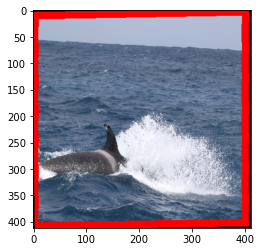

In [126]:
import tensorflow_addons as tfa
import tensorflow as tf

img_ts = tf.convert_to_tensor(imgs[3] / 255.0)
# transform = tfa.image.transform(img_ts, [1.0, 2.0, -250, 0.0, 1.0, 0.0, 0.0, 0.0])
deg = tf.random.uniform([], -15, 15)
print(deg)
transform = tfa.image.shear_x(img_ts, deg * np.pi/180, 0.0)
transform = tfa.image.rotate(transform, deg * np.pi/180)
plt.imshow(transform)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.615632>

In [ ]:
def random_perspective(im, degrees=30, translate=.1, scale=.1, shear=10, perspective=0.0,
                       border=(0, 0)):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-10, 10))
    # targets = [cls, xyxy]

    height = im.shape[0] + border[0] * 2  # shape(h,w,c)
    width = im.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -im.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -im.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            im = cv2.warpPerspective(im, M, dsize=(width, height), borderValue=(0, 0, 0))
        else:  # affine
            im = cv2.warpAffine(im, M[:2], dsize=(width, height), borderValue=(0, 0, 0))

    return im